In [10]:
import numpy as np
import torch as tr
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch

import torch.nn as nn
import torch.nn.functional as F



import torch.optim as optim
import torchvision.transforms as transforms
# from torchvision.datasets import CIFAR10
# from torch.utils.data import DataLoader
from tqdm.notebook import tqdm as tqdm

import matplotlib.pyplot as plt
import itertools


https://theaisummer.com/simclr/#indexing-the-similarity-matrix-for-the-simclr-loss-function

## Data loading- medical MNIST

In [3]:
# Define a function to convert grayscale images to RGB
def grayscale_to_rgb(img):
    return torch.cat((img, img, img), dim=0)

# Set up the data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST training dataset
train_set = datasets.MNIST(
    root='./data',
    train=True,
    download=False,
    transform=transform
)

# Create a PyTorch DataLoader for the training set
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=12,
    shuffle=True
)

# Load the MNIST test dataset
test_set = datasets.MNIST(
    root='./data',
    train=False,
    download=False,
    transform=transform
)

# Create a PyTorch DataLoader for the test set
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=12,
    shuffle=False
)

Text(0.5, 1.0, 'Label: 9')

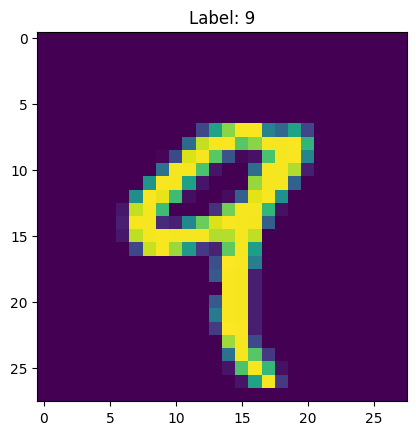

In [9]:
# Sanity check to make sure we can access data / labels
idx = 4
plt.imshow(train_set.data[idx])
plt.title(f"Label: {train_set.targets[idx]}")

AttributeError: 'list' object has no attribute 'batch_size'

In [ ]:
train_loader.dataset.

In [24]:
# Get the first 10 samples from the DataLoader for debugging
sub_train_loader = list(itertools.islice(train_loader, 10))


for i, (inputs, targets) in enumerate(sub_train_loader):

    print(f'Batch {i}, Inputs shape: {inputs.shape}, Targets shape: {targets.shape}')

print(f"\nbatch size: {train_loader.batch_size}, image dims (H,W): {inputs.size()[2:]}")



Batch 0, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 1, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 2, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 3, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 4, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 5, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 6, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 7, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 8, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 9, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])

batch size: 12, image dims (H,W): torch.Size([28, 28])


## Model  

In [23]:

# Define the SimCLR network architecture
class SimCLR(nn.Module):
    def __init__(self,verbose=False):
        super(SimCLR, self).__init__()
        # this is f(*) in the paper
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 28, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(28, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # this is g(*) in the paper
        self.projector = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.verbose = verbose

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        z = self.projector(h)
        if self.verbose:
            print('batch size is ',x.shape)
            print('encoded size is ',h.shape)
            print('final size is ',z.shape)
        return h,z

# model = SimCLR() # how to initalize a model
# h, z = model(inputs) # how to forward pass a batch

## Transforms

In [32]:
def transform_init(inputs):
    """
    Initial transformation function that returns
    two images- one is the identity the second is a random
    crop & resize of the original image

    eventually, this will be made into a flexible function 
    with multiple transform options

    params
    ------
    x : tensor (N, C, H, W)
        batch of train images to transform

    returns
    -------
    x_i : tensor (N, C, H, W)
        identity transform of inputs
    x_j : tensor (N, C, H, W)
        ransom resize and crop of inputs
    """

    x_i = inputs
    x_j =  torchvision.transforms.functional.resized_crop(
        inputs,
        top=8,
        left=8,
        height=12,
        width=12,
        size=(28,28)
    )

    return x_i, x_j

In [38]:
def visualize_batch_transform(x_i,x_j):
  """
  Plot for visualing a transform
  pair of an image x
  """

  N,C,H,W = x_i.shape
  Nplt = np.min([5,N])
  
  fig,axarr = plt.subplots(Nplt,2,figsize=(8,3*Nplt))

  for ix in range(Nplt):

    ax1 = axarr[ix,0]
    ax2 = axarr[ix,1]

    ax1.imshow(x_i[ix,0])
    ax2.imshow(x_j[ix,0])
    if ix == 0:
      ax1.set_title("x_i image")
      ax2.set_title("x_j image")

  return None

In [39]:
x_i, x_j = transform_init(inputs)


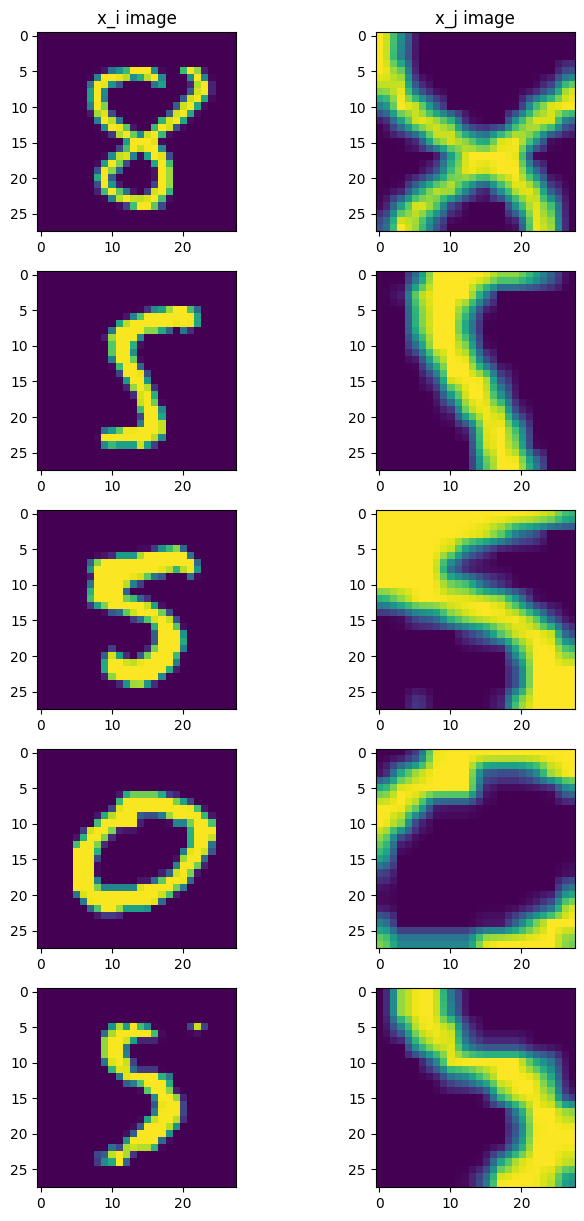

In [40]:
visualize_batch_transform(x_i,x_j)

## Loss

In [55]:
def device_as(t1, t2):
   """
   Moves t1 to the device of t2
   """
   return t1.to(t2.device)
class ContrastiveLoss(nn.Module):
   """
   Vanilla Contrastive loss, also called InfoNceLoss as in SimCLR paper
   """
   def __init__(self, batch_size, temperature=0.5):
       super().__init__()
       self.batch_size = batch_size
       self.temperature = temperature
       self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()

   def calc_similarity_batch(self, a, b):
       representations = torch.cat([a, b], dim=0)
       return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

   def forward(self, proj_1, proj_2):
       """
       proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
       where corresponding indices are pairs
       z_i, z_j in the SimCLR paper
       """
       batch_size = proj_1.shape[0]
       z_i = F.normalize(proj_1, p=2, dim=1)
       z_j = F.normalize(proj_2, p=2, dim=1)

       similarity_matrix = self.calc_similarity_batch(z_i, z_j)

       sim_ij = torch.diag(similarity_matrix, batch_size)
       sim_ji = torch.diag(similarity_matrix, -batch_size)

       positives = torch.cat([sim_ij, sim_ji], dim=0)

       nominator = torch.exp(positives / self.temperature)

       denominator = device_as(self.mask, similarity_matrix) * torch.exp(similarity_matrix / self.temperature)

       all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
       loss = torch.sum(all_losses) / (2 * self.batch_size)
       return loss

## Eval

In [78]:
def linear_regression(x, y):
    """
    Function to assess if the embedding space with a contrastive
    loss improves predictions compared to image transformed with
    identitiy (e.g no transformation)

    params
    ------
    x : tensor size: (n, :)
        input (image, embedding, etc)
    y : tensor size: (n,)
        class labels
    
    returns
    
    dist : float
        euclidian distance between predicted and actual labels 
        for a batch. 
    """

    # flatten x to be (n_batches x n_features)
    n_batches = x.size()[0]
    x_flat = x.reshape(n_batches, -1)

    # pad y to be (n_batches x 1) & float
    y_pad = y.float().unsqueeze(1) 

    W = torch.linalg.lstsq(x_flat, y_pad).solution
    dist = torch.dist(W, torch.linalg.pinv(x_flat) @ y_pad)

    return dist


## Train

0

In [91]:
model = SimCLR()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = ContrastiveLoss(train_loader.batch_size)

In [92]:
num_epochs = 100
loss = -99 * np.ones((num_epochs))
base_metric = -99 * np.ones((num_epochs))
embedding_metic = -99 * np.ones((num_epochs))

for ep in range(num_epochs):
    loss_epoch = 0
    for i, (inputs, targets) in enumerate(sub_train_loader):
        optimizer.zero_grad()
        
        x_i, x_j = transform_init(inputs)

        h_i, z_i = model(x_i)
        h_j, z_j = model(x_j)

        batch_loss = criterion(z_i, z_j)
        batch_loss.backward()
        optimizer.step()
        loss_epoch += batch_loss.item()
    

    loss[ep] = loss_epoch
    base_metric[ep] = linear_regression(x_i, targets)
    embedding_metic[ep] = linear_regression(h_i.detach(), targets)

## Eval 

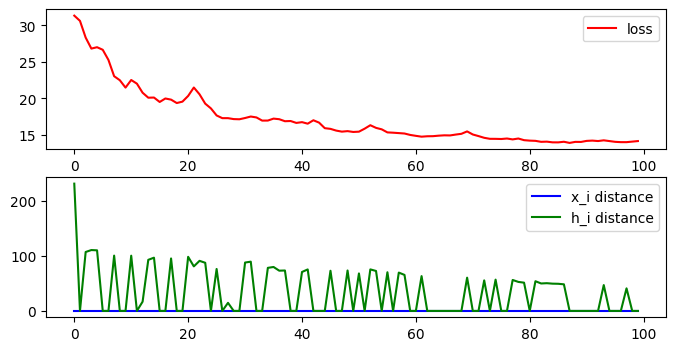

In [93]:
fig,ax = plt.subplots(2, 1, figsize=(8,4))

ax[0].plot(loss, color = "red", label = "loss")
ax[1].plot(base_metric, color = "blue", label="x_i distance")
ax[1].plot(embedding_metic, color = "green", label="h_i distance")

ax[0].legend()
ax[1].legend()